<a href="https://colab.research.google.com/github/sftSalman/tensoflowMaster/blob/main/classification_and_localizationMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.2


In [2]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)

In [3]:
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select Appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth
  # between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back
  print("Running on TPU", tpu.cluster_spec().as_dict()["worker"])
elif len(gpus)>1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print("Running on multiple GPUs", [gpu.name for gpu in gpus])
elif len(gpus)==1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print("Running on single GPU", gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() 
  print("Running on CPU")
print("Number of acceleratorsL ", strategy.num_replicas_in_sync)

Running on CPU
Number of acceleratorsL  1


In [5]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [6]:
def read_image_tfds(image, label):
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  image = tf.cast(image, tf.float32) / 255.0
  x_min = tf.cast(x_min, tf.float32)
  y_min = tf.cast(y_min, tf.float32)

  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min = x_min / 75
  y_min = y_min / 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

In [7]:
def get_training_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True) # Google Cloud Storage
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # mandatory for Keras for now
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)# drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

In [8]:
def get_training_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True) # Google Cloud Storage
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # mandatory for Keras for now
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)# drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

"""
Loads and maps the validation split of the dataset using th map function. Same as Training ver
"""
def get_validation_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # dataset = dataset.cached() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

# Instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

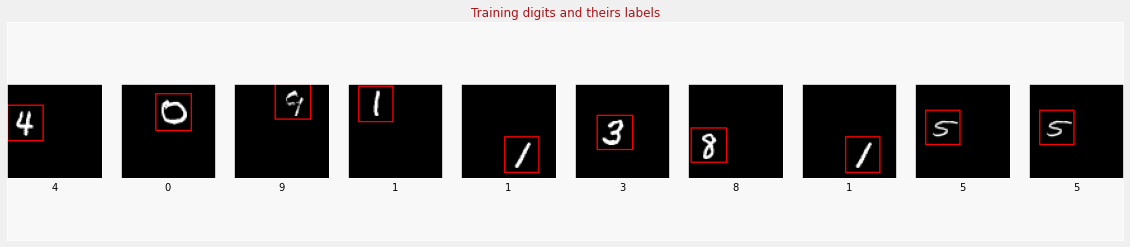

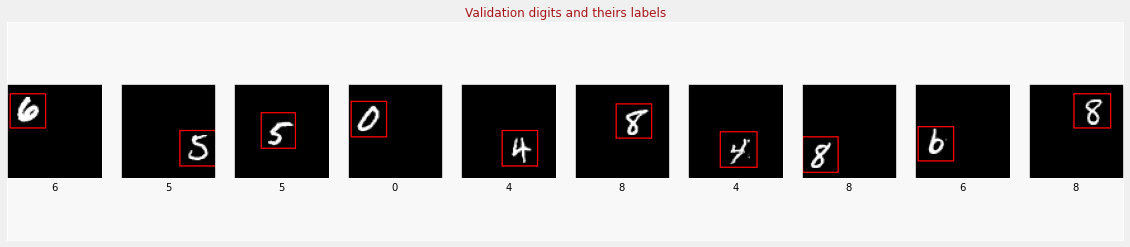

In [9]:
(training_digits, training_labels, training_bboxes, 
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, 
                                                                                  validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, 
                          np.array([]), training_bboxes,np.array([]), "Training digits and theirs labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, 
                          np.array([]), validation_bboxes,np.array([]), "Validation digits and theirs labels")